In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tables
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton 
import calibrate
import pandas as pd
from scipy.special import erf
import glob
import re
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator, CubicSpline, PchipInterpolator, PPoly, interpolate
from scipy.signal import butter,filtfilt

In [3]:
Es = 440
sim_particles = 1000000
sim_depths = 7
mu_low, mu_high = -0.4, 1
lever_thres = 14

In [4]:
arr = []
for file in glob.glob("/Users/eframe/geant4py/output440/*"):
    src = tables.open_file(file)
    rawdata = pd.DataFrame(src.root.raw.data[:])
    src.close()
    
    # Doubles Filter for Compton Events
    imask = ( rawdata['interaction'] >= 0 ) & ( rawdata['interaction'] <= 1 )
    data = rawdata[imask]
    smask = data.groupby(['eventID'])['trackID'].sum().values > 1 
    smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 2 # Doubles Events Only
    
    # Energy Filter
    emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == Es
    
    gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
    gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
    gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
    
    gx2 = data.groupby(['eventID']).nth(1)['gx'][smask2][emask]
    gy2 = data.groupby(['eventID']).nth(1)['gy'][smask2][emask]
    gz2 = data.groupby(['eventID']).nth(1)['gz'][smask2][emask]
    
    pos1 = np.array([gx1, gy1, gz1]).T
    pos2 = np.array([gx2, gy2, gz2]).T
    
    E2 = data.groupby(['eventID']).nth(1)['E'][smask2][emask]
  
    coneMu = ( 1 + 511 * ( 1 / Es - 1 / E2 ) )
    mask2 = ( coneMu > mu_low ) & ( coneMu < mu_high )

    coneAxes = pos2 - pos1
    lever = np.sqrt( ( coneAxes ** 2 ).sum( axis = 1 ) )
    mask3 = lever[mask2] >= lever_thres

    # Computing sensitivity
    doubles = lever[mask2][mask3]
    sens = len(doubles) / sim_particles
        
    # Source Position from Filename
    posx = int( re.search(r'x(.*)y', file).group(1) )
    posy = int( re.search(r'x(.*)y(.*)z', file).group(2) )
    posz = int( re.search(r'z(.*).h5', file).group(1) )
    
    arr.append([posx, posy, posz, sens])

In [5]:
# Build Quarter Sensitivity Table and Save to File
df = pd.DataFrame(data=arr, columns=['x', 'y', 'z', 'sens']).sort_values(by=['x', 'y', 'z']).reset_index(drop = True)
df.to_hdf('/Users/eframe/dmi/quarterSens440.h5', key='vals', mode='w')

In [28]:
# Read Quarter Sensitivity Table 
table = pd.read_hdf('/Users/eframe/dmi/quarterSens440.h5', 'vals')
mask = ( ( table['x'].values >= 0 ) & ( table['x'].values <= 100 ) ) &\
        ( ( table['y'].values >= 0 ) & ( table['y'].values <= 100 ) ) &\
        ( ( table['z'].values >= 0 ) & ( table['z'].values <= 120 ) )
table = table[mask]

1


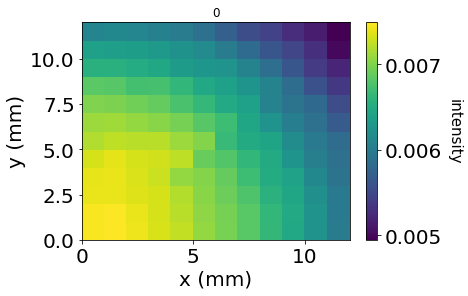

11


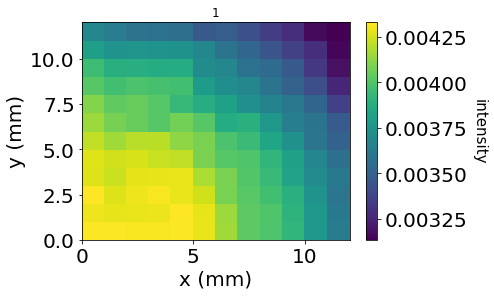

21


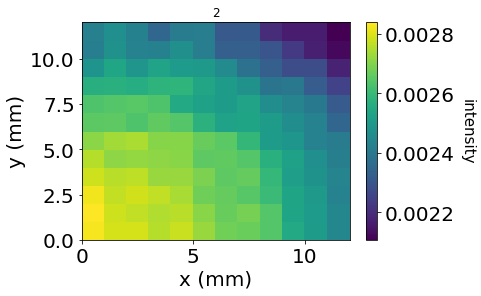

31


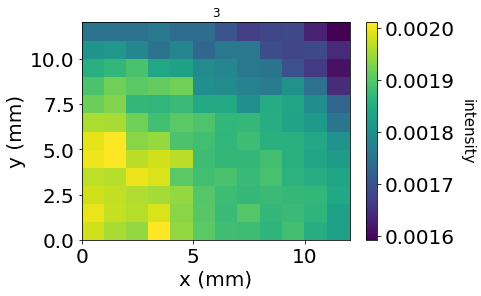

41


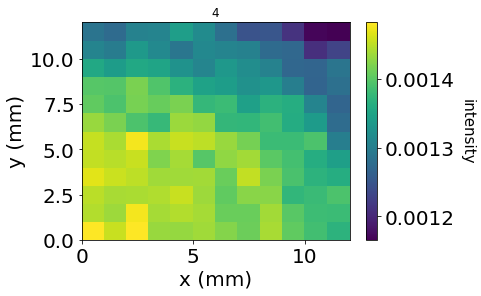

51


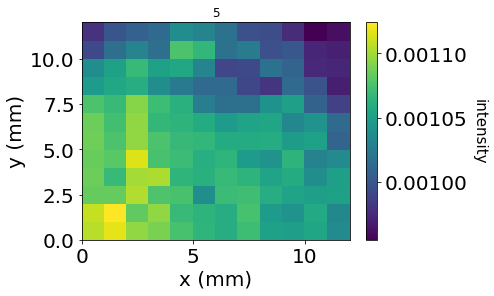

61


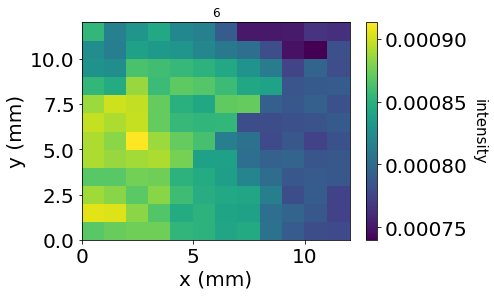

In [29]:
quartvals = table['sens'].values.reshape((12, 12, 7))
depth = table[:7]['z'].values
a, b = min( quartvals.flatten() ), max( quartvals.flatten() )
for i in np.arange( len(depth) ):
    print( depth[i] )
    fig, ax = plt.subplots()
    grid = quartvals[:, :, i]
    im = ax.pcolormesh( grid.T ) 
    ax.set_xlabel('x (mm)', fontsize=20)
    ax.set_ylabel('y (mm)', fontsize=20)
    ax.tick_params(labelsize=20)
    cbar = plt.colorbar(im)
    cbar.set_label(label='intensity', rotation=270, fontsize=15, labelpad=20)
    cbar.ax.tick_params(labelsize=20)
    plt.title(i)
    plt.show()

In [30]:
# Depth Interpolation on Quarter Sensitivity Table
zint = 7 # number of depths simulated in geant4
sens = table['sens'].values.reshape( ( int( len(table ) / zint ), zint ) )
x = table['x'].values.reshape( ( int( len(table) / zint ), zint ) )[:, 0]
y = table['y'].values.reshape( ( int( len(table) / zint ), zint ) )[:, 0]
z = table['z'].values.reshape( ( int( len(table) / zint ), zint ) )

data_frames = []
for i in np.arange( len(sens) ):
    zs = np.arange(1, 101, 1)
    xs = x[i].repeat(len(zs))
    ys = y[i].repeat(len(zs))
    a, b, c = np.polyfit(np.log(z[i]), sens[i], 2)
    vals = a * np.log(zs) ** 2 + b * np.log(zs) + c
    df = pd.DataFrame({'x': xs, 'y':ys, 'z':zs, 'sens':vals})
    data_frames.append(df)
depthTab = pd.concat(data_frames, sort=False).sort_values(by=['x', 'y', 'z']).drop_duplicates()

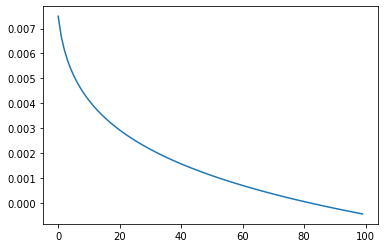

In [31]:
plt.plot(depthTab['sens'][:100].values)
plt.show()

In [44]:
# Lateral Interpolation on Quarter Sensitivity Table
samp = 22
idx = 2
xidx = np.arange(0, samp+1, idx)
yidx = np.arange(0, samp+1, idx)
zidx = np.arange(1, 101, 1)
data = depthTab['sens'].values.reshape( len(xidx), len(yidx), len(zidx) )

my_interpolating_function = RegularGridInterpolator( (xidx, yidx, zidx), data, method='linear' )
xNew, yNew, zNew = np.mgrid[ 0:samp+1, 0:samp+1, 1:101 ]
idxNew = np.array([ xNew.flatten(), yNew.flatten(), zNew.flatten() ]).T.tolist()

sensNew = my_interpolating_function(idxNew)

In [45]:
# Reflect Quarter Sensitivity Table Across Axes
sens1 = sensNew.reshape( xNew.shape )
x1, y1, z1 = np.mgrid[ 0:samp+1:1, 0:samp+1:1, 1:101 ]
df1 = pd.DataFrame( {'x': x1.flatten(), 'y':y1.flatten(), 'z': z1.flatten(), 'sens':sens1.flatten()} ).sort_values(by=['x', 'y', 'z']).drop_duplicates()

sens2 = np.flip(sens1, axis=1)
x2, y2, z2 = np.mgrid[ 0:samp+1:1, -(samp):1:1, 1:101 ]
df2 = pd.DataFrame( {'x': x2.flatten(), 'y':y2.flatten(), 'z': z2.flatten(), 'sens':sens2.flatten()} ).sort_values(by=['x', 'y', 'z']).drop_duplicates()

sens3 = np.flipud(sens2)
x3, y3, z3 = np.mgrid[ -(samp):1:1, -(samp):1:1, 1:101 ]
df3 = pd.DataFrame( {'x': x3.flatten(), 'y':y3.flatten(), 'z': z3.flatten(), 'sens':sens3.flatten()} ).sort_values(by=['x', 'y', 'z']).drop_duplicates()

sens4 = np.flip(sens1, axis=0)
x4, y4, z4 = np.mgrid[ -(samp):1:1, 0:samp+1:1, 1:101 ]
df4 = pd.DataFrame( {'x': x4.flatten(), 'y':y4.flatten(), 'z': z4.flatten(), 'sens':sens4.flatten()} ).sort_values(by=['x', 'y', 'z']).drop_duplicates()

df = pd.concat( [df1, df2, df3, df4] ).sort_values( by = ['x', 'y', 'z'], ascending = [ True, True, True ] ).drop_duplicates(subset=['x', 'y', 'z'])

In [46]:
df.to_hdf( '/Users/eframe/dmi/sensMap.h5', key='vals', mode='w' )
sens = df['sens'].values

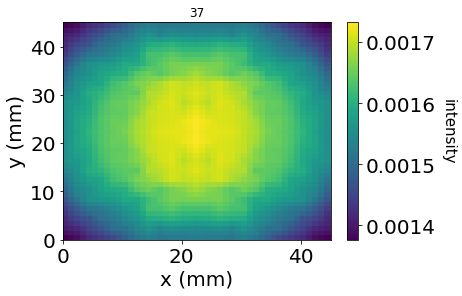

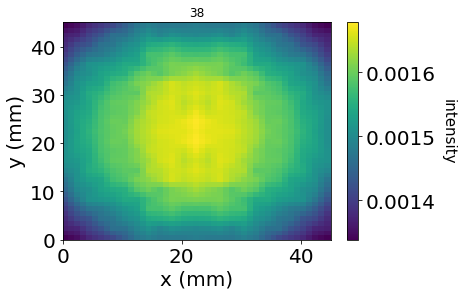

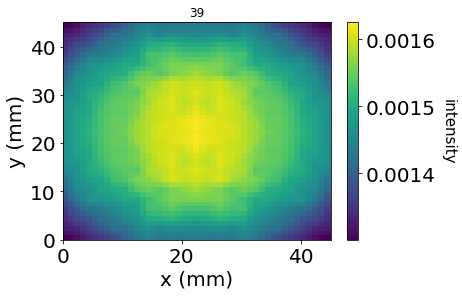

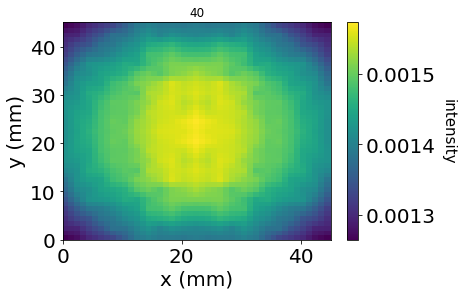

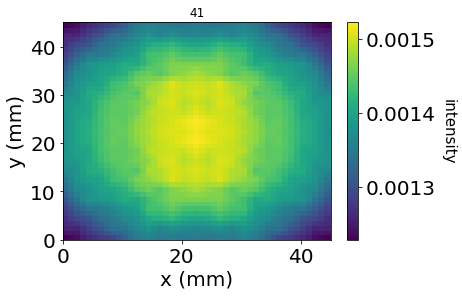

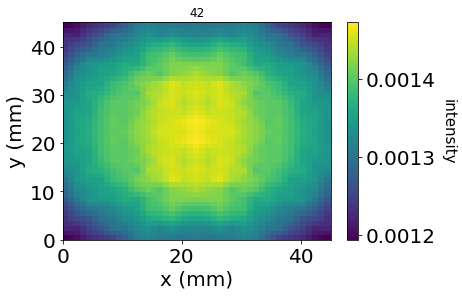

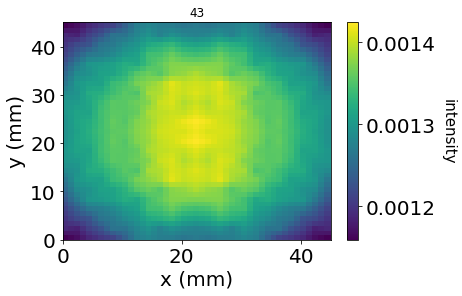

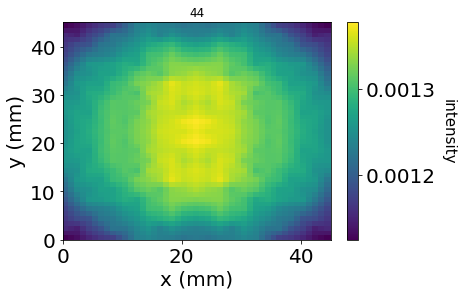

In [47]:
%matplotlib inline
sX, sY, sZ = np.mgrid[ -samp:samp+1, -samp:samp+1, 1:101:1 ]
depth = np.array( sZ[:,0][0] )[:] 
xmin, xmax = sX[:,0][:,0][0], sX[:,0][:,0][-1] + 1
ymin, ymax = sY[0,:][:,0][0], sY[0,:][:,0][-1] + 1
X, Y = np.mgrid[  xmin:xmax:1, ymin:ymax:1 ]
sens = sens.reshape(sZ.shape)
a, b = min( sens.flatten() ), max( sens.flatten() )
for i in np.arange( 37, 45 ):
    fig, ax = plt.subplots()
    grid = sens[:, :, i]
    im = ax.pcolormesh( grid.T ) 
    ax.set_xlabel('x (mm)', fontsize=20)
    ax.set_ylabel('y (mm)', fontsize=20)
    ax.tick_params(labelsize=20)
    cbar = plt.colorbar(im)
    cbar.set_label(label='intensity', rotation=270, fontsize=15, labelpad=20)
    cbar.ax.tick_params(labelsize=20)
    plt.title(i)
    plt.show()

In [48]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [49]:
# Filter requirements
fs = 10          # sample rate, Hz
cutoff = 0.5    # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 1       # sin wave can be approx represented as quadratic
n = len(sens)   # total number of samples
 
sens_filt1 = np.zeros( sens.shape)
sens_filt2 = np.zeros( sens.shape )
for k in np.arange(sens.shape[2]):
    for j in np.arange(sens.shape[1]):
        sens_filt1[:,j,k] = butter_lowpass_filter( sens[:,j,k], cutoff, fs, order )
        sens_filt2[j,:,k] = butter_lowpass_filter( sens[j,:,k], cutoff, fs, order )

In [50]:
sens_filt = ( sens_filt1 + sens_filt2  ) / 2

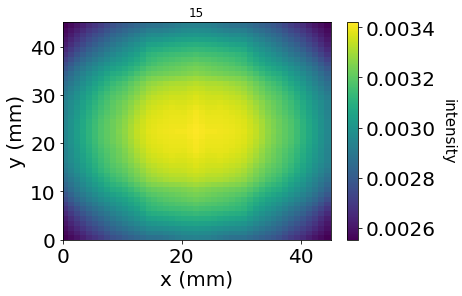

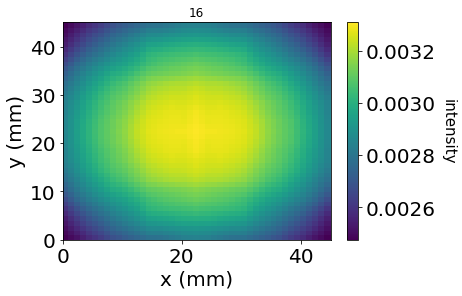

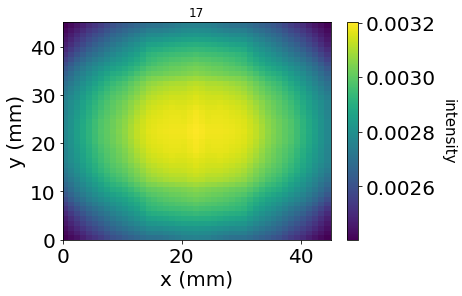

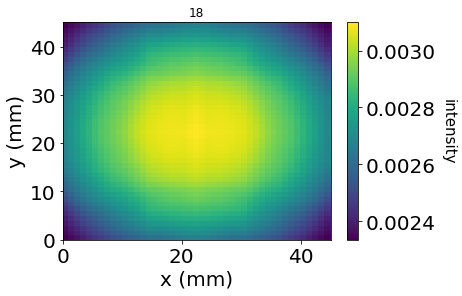

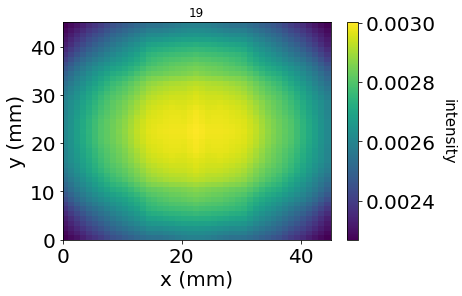

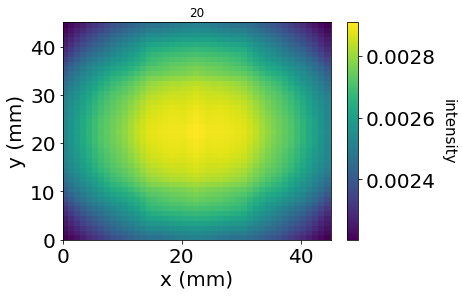

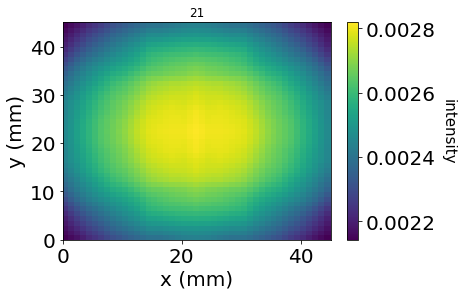

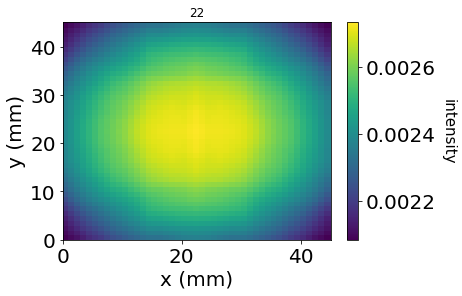

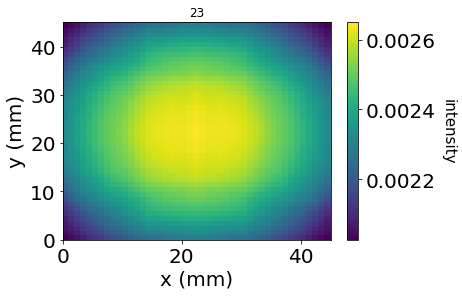

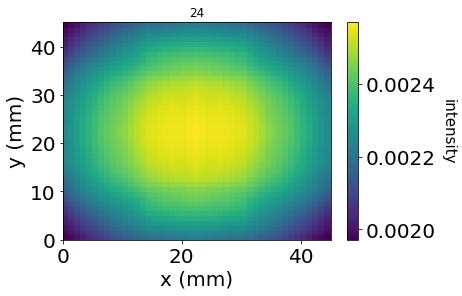

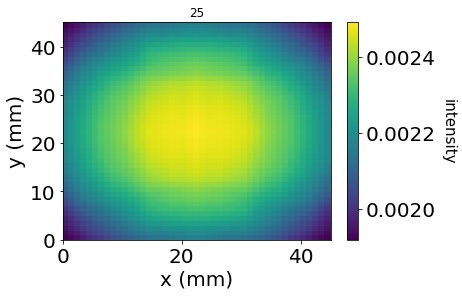

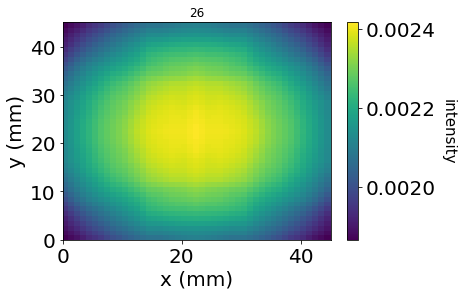

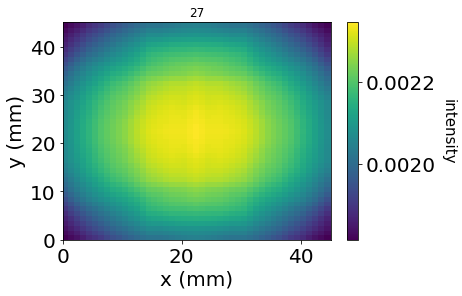

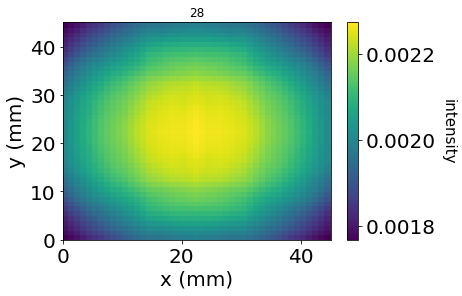

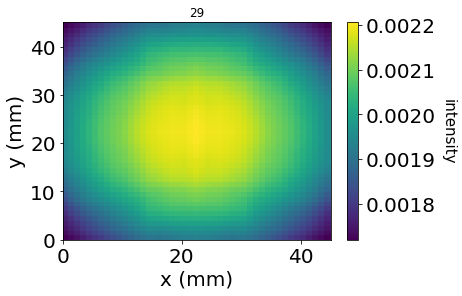

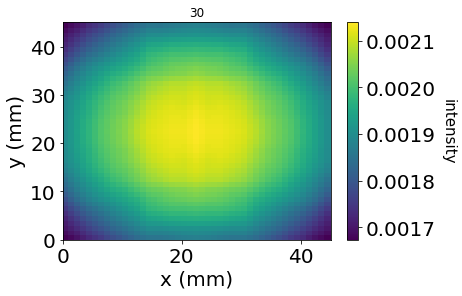

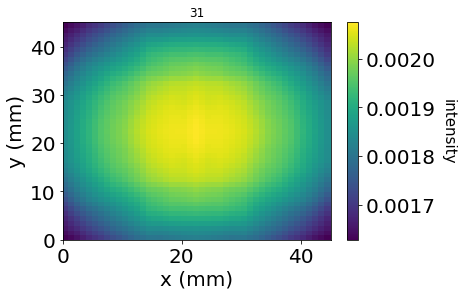

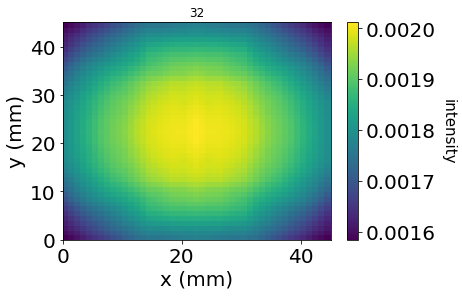

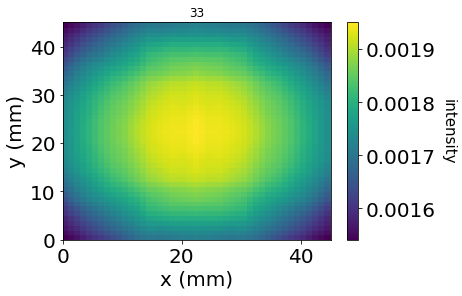

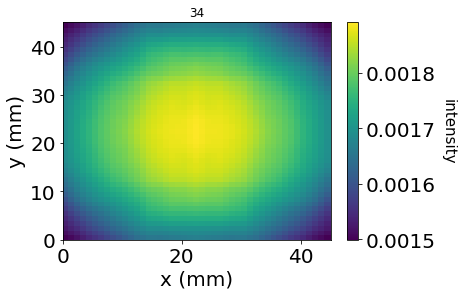

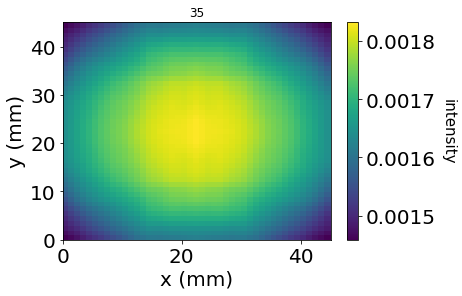

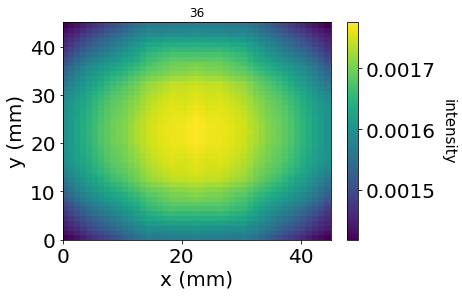

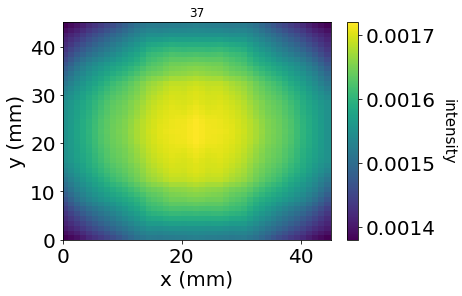

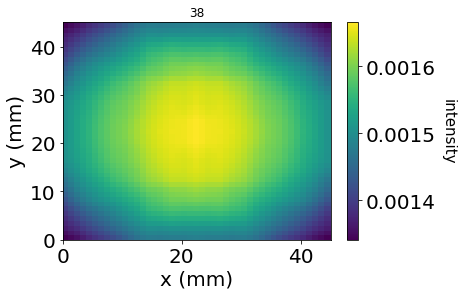

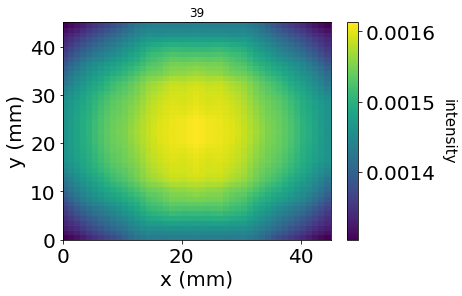

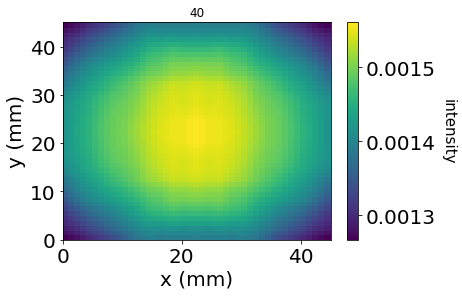

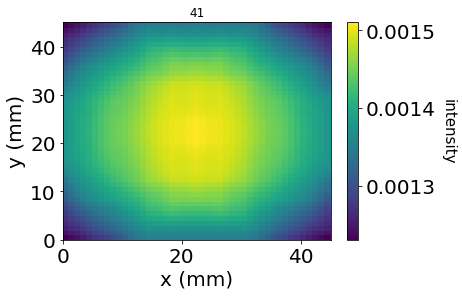

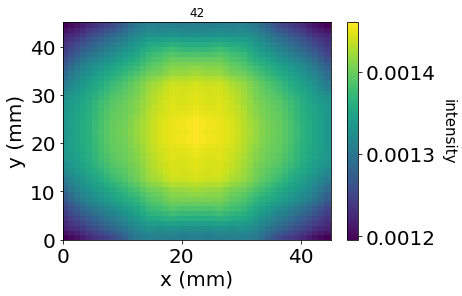

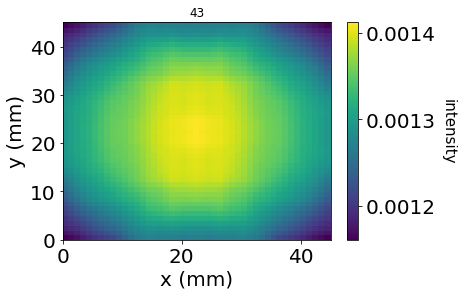

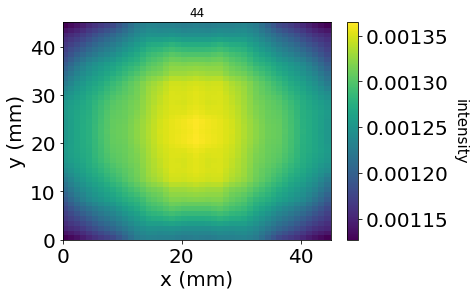

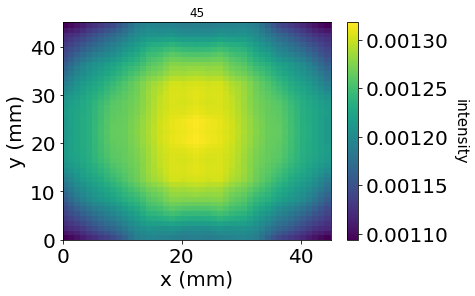

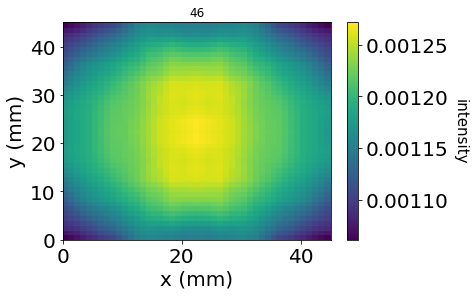

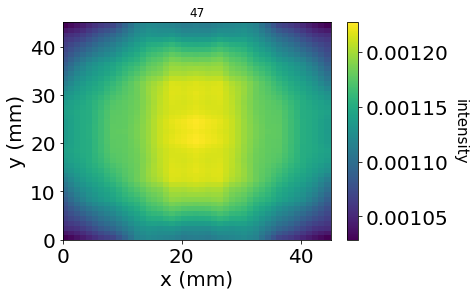

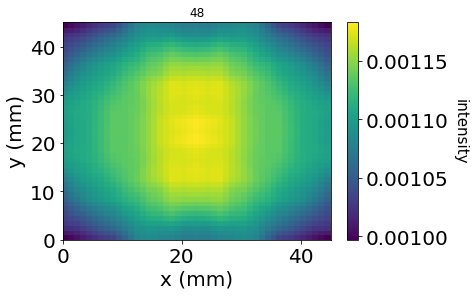

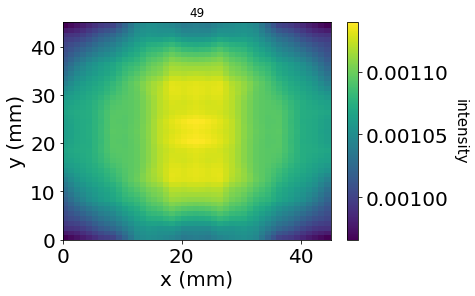

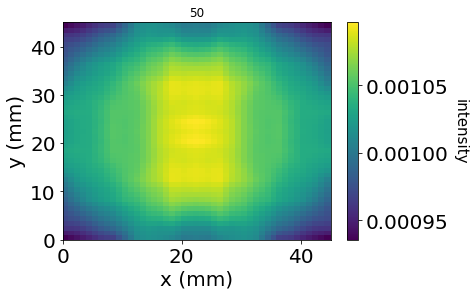

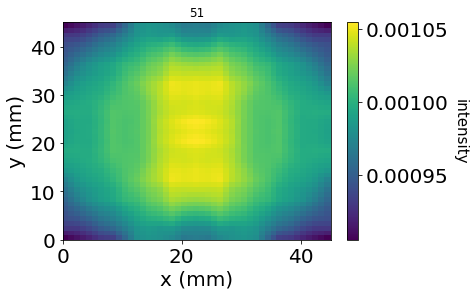

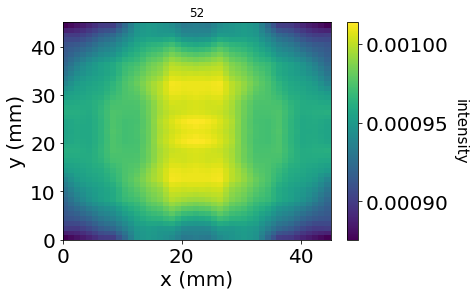

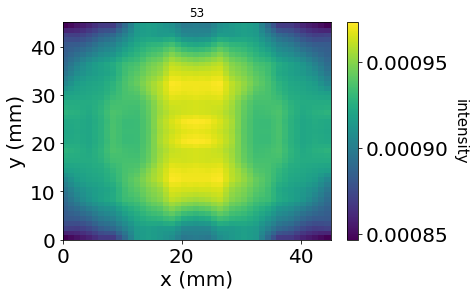

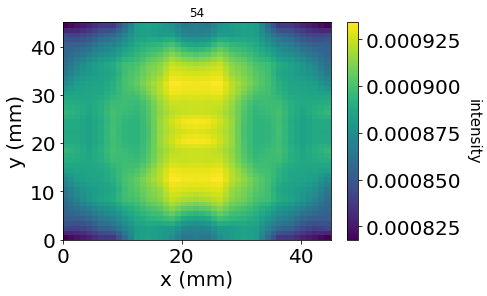

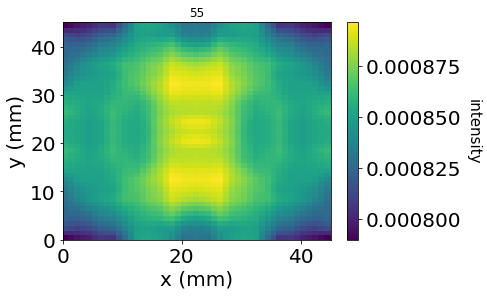

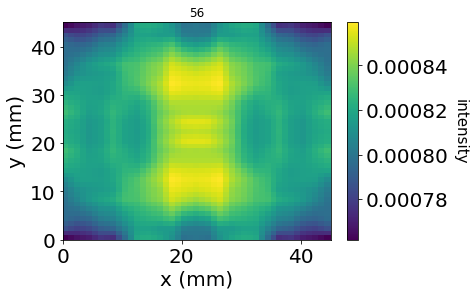

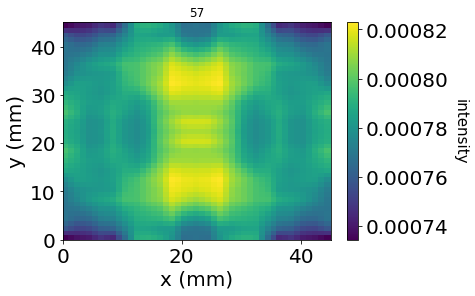

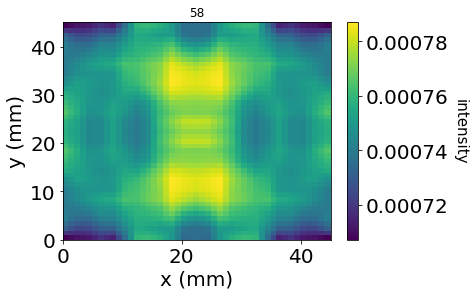

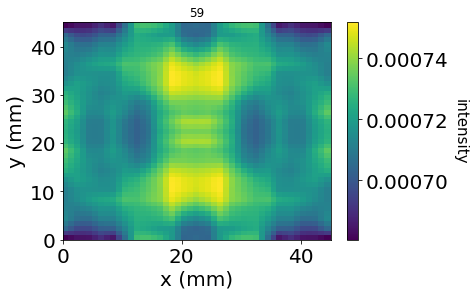

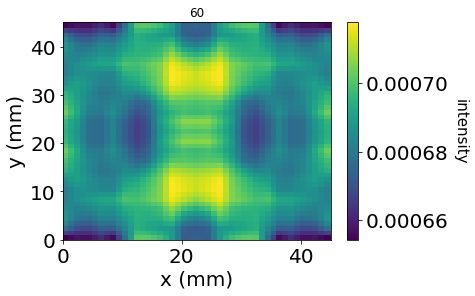

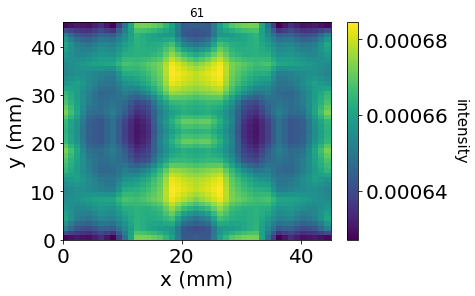

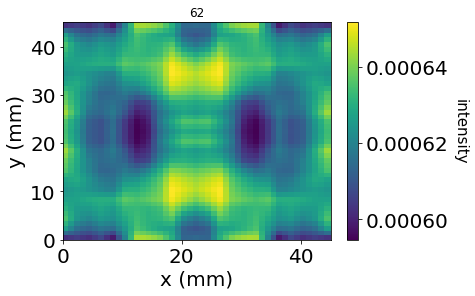

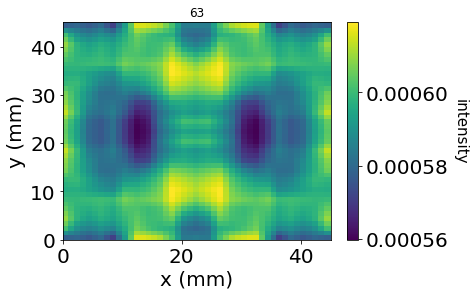

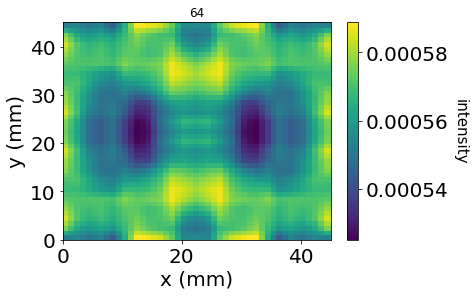

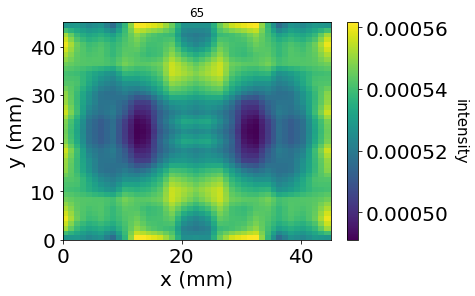

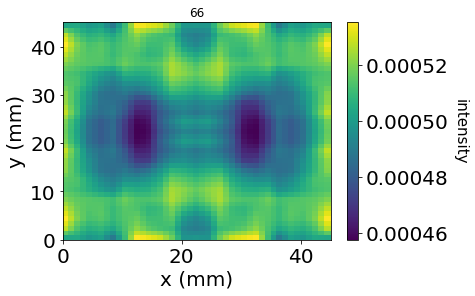

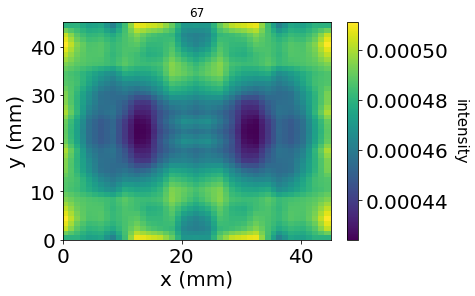

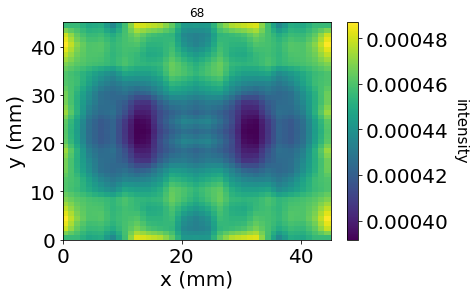

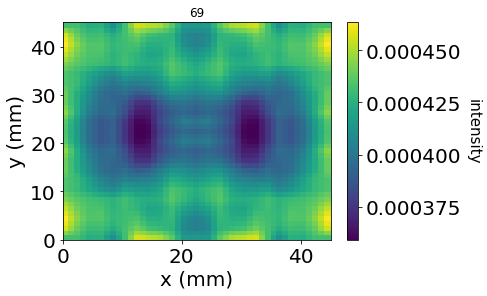

In [52]:
%matplotlib inline
sX, sY, sZ = np.mgrid[ -samp:samp+1, -samp:samp+1, 3:103:1 ]
depth = np.array( sZ[:,0][0] )[:] 
a, b = min( sens_filt.flatten() ), max( sens_filt.flatten() )
for i in np.arange( 15, 70 ):
    fig, ax = plt.subplots()
    grid = sens_filt[:, :, i]
    im = ax.pcolormesh( grid.T ) 
    ax.set_xlabel('x (mm)', fontsize=20)
    ax.set_ylabel('y (mm)', fontsize=20)
    ax.tick_params(labelsize=20)
    cbar = plt.colorbar(im)
    cbar.set_label(label='intensity', rotation=270, fontsize=15, labelpad=20)
    cbar.ax.tick_params(labelsize=20)
    plt.title(i)
    plt.show()

In [53]:
df2 = df.copy()
df2['sens'] = sens_filt.flatten()
df2.to_hdf( '/Users/eframe/dmi/sensMap.h5', key='vals', mode='w' )

In [ ]:
# # Histogramming Sensitivities over Image Space
# binSize = 2
# sourceX, sourceY, sourceZ = np.mgrid[ -49:51:binSize, -49:51:binSize, -49:51:binSize ]
# sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T + np.array([0,0,50])
# senstable = pd.read_hdf( '/Users/eframe/dmi/sensMapFilter2.h5', 'vals' )

# sensMap = np.zeros( len(sourcePixels) )    
# for j in np.arange( sourcePixels.shape[0] ):
#     x = np.round( sourcePixels[ j, 0 ] ).astype(int)
#     y = np.round( sourcePixels[ j, 1 ] ).astype(int)
#     z = np.round( sourcePixels[ j, 2 ] ).astype(int)
#     ix = 301 * 601 * ( 301 + x ) 
#     iy = 301 * ( 301 + y )
#     iz = z 
#     sens = senstable[ix - ( 301 * 601 ):ix][iy - 301:iy][iz:iz+1]['sens'].values
#     sensMap[j] = sens
    
# hist, bins = np.histogram(sensMap, bins=500)
# plt.plot(bins[:-1], hist)
# plt.xlabel('sensitivity')
# plt.ylabel('# of voxels')
# plt.show()